In [1]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from data_loader import AadhaarDataLoader
from preprocessing import AadhaarDataPreprocessor
from visualization import AadhaarVisualizer

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load Processed Data

Load the cleaned and enhanced datasets from preprocessing notebook

In [2]:
# Load processed data
print("Loading processed datasets...")

enrolment_df = pd.read_parquet('../outputs/enrolment_processed.parquet')
demographic_df = pd.read_parquet('../outputs/demographic_processed.parquet')
biometric_df = pd.read_parquet('../outputs/biometric_processed.parquet')

print(f"✓ Enrolment: {len(enrolment_df):,} records")
print(f"✓ Demographic: {len(demographic_df):,} records")
print(f"✓ Biometric: {len(biometric_df):,} records")

# Initialize visualizer
visualizer = AadhaarVisualizer(output_dir='../outputs/figures')

Loading processed datasets...
✓ Enrolment: 200,255 records
✓ Demographic: 395,409 records
✓ Biometric: 368,316 records


## 2. UNIVARIATE ANALYSIS

### 2.1 Enrolment Data - Age Group Distribution

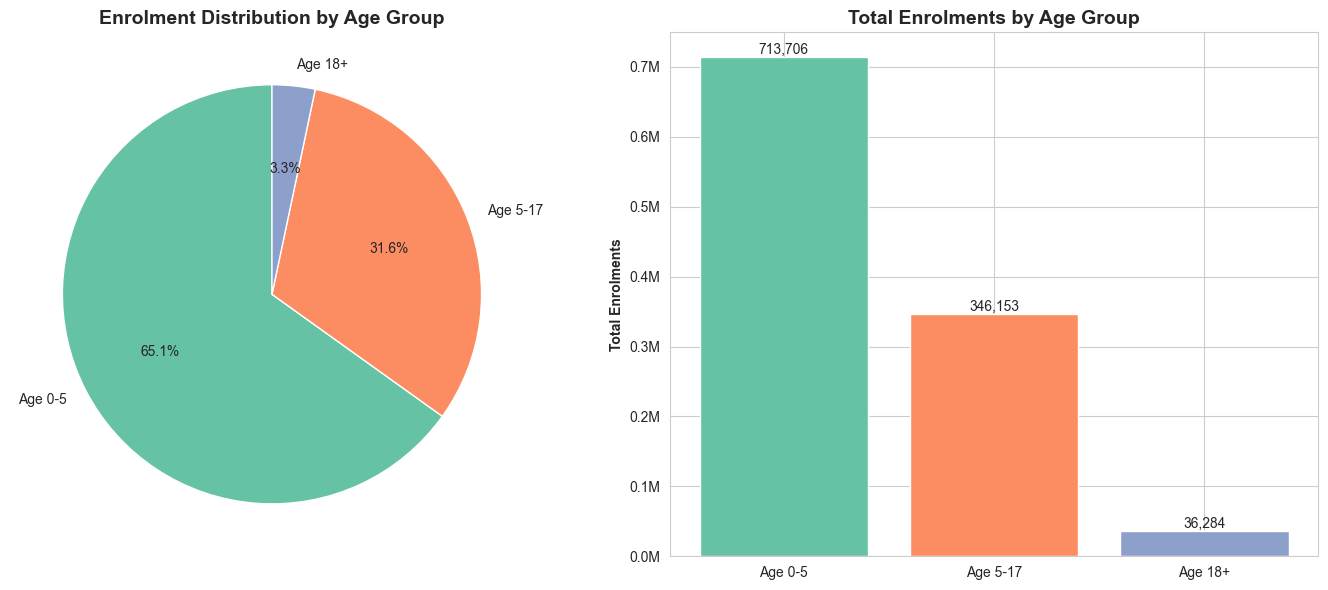


Age Group Statistics:
  Age 0-5: 713,706 (65.1%)
  Age 5-17: 346,153 (31.6%)
  Age 18+: 36,284 (3.3%)


In [3]:
# Age group distribution in enrolments
age_totals = {
    'Age 0-5': enrolment_df['age_0_5'].sum(),
    'Age 5-17': enrolment_df['age_5_17'].sum(),
    'Age 18+': enrolment_df['age_18_greater'].sum()
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
colors = sns.color_palette('Set2', 3)
ax1.pie(age_totals.values(), labels=age_totals.keys(), autopct='%1.1f%%', 
        startangle=90, colors=colors)
ax1.set_title('Enrolment Distribution by Age Group', fontweight='bold', fontsize=14)

# Bar chart
ax2.bar(age_totals.keys(), age_totals.values(), color=colors)
ax2.set_ylabel('Total Enrolments', fontweight='bold')
ax2.set_title('Total Enrolments by Age Group', fontweight='bold', fontsize=14)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

for i, (k, v) in enumerate(age_totals.items()):
    ax2.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../outputs/figures/01_age_distribution_enrolment.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAge Group Statistics:")
total = sum(age_totals.values())
for age, count in age_totals.items():
    print(f"  {age}: {count:,} ({count/total*100:.1f}%)")

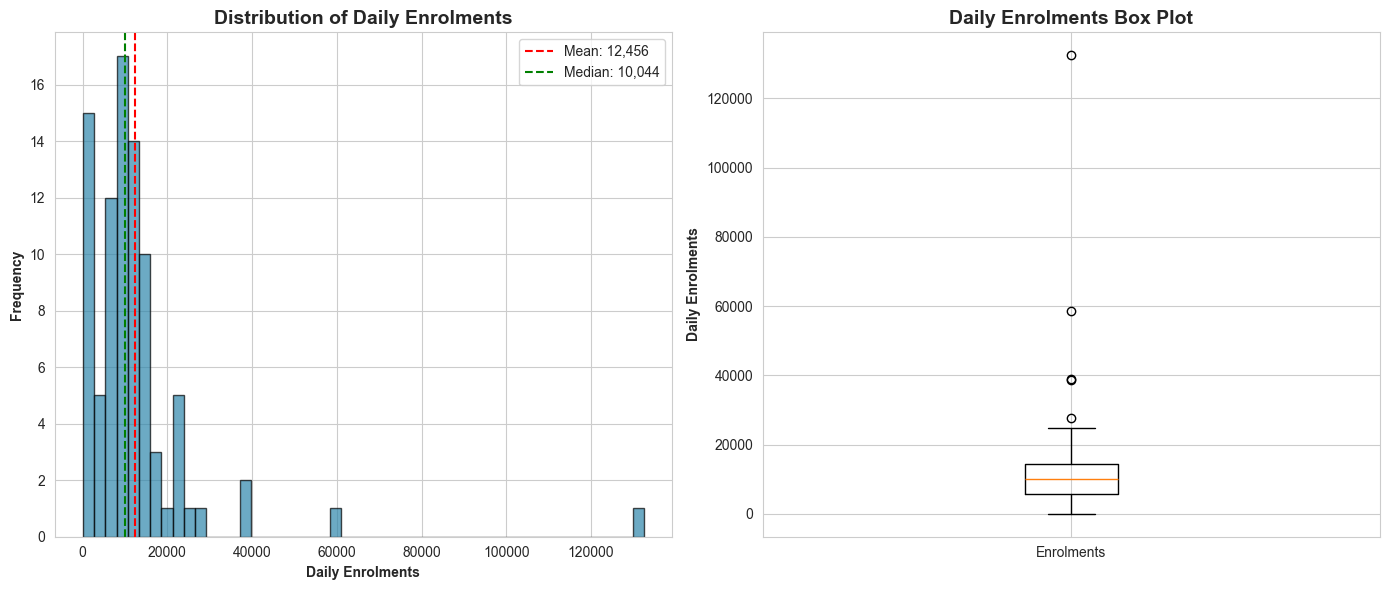


Daily Enrolment Statistics:
count        88.000000
mean      12456.170455
std       15884.947655
min          49.000000
25%        5866.750000
50%       10044.000000
75%       14461.250000
max      132479.000000
Name: total_enrolments, dtype: float64


In [4]:
# Distribution of daily enrolments
daily_enrolments = enrolment_df.groupby('date')['total_enrolments'].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
ax1.hist(daily_enrolments, bins=50, color='#2E86AB', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Daily Enrolments', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Distribution of Daily Enrolments', fontweight='bold', fontsize=14)
ax1.axvline(daily_enrolments.mean(), color='red', linestyle='--', label=f'Mean: {daily_enrolments.mean():,.0f}')
ax1.axvline(daily_enrolments.median(), color='green', linestyle='--', label=f'Median: {daily_enrolments.median():,.0f}')
ax1.legend()

# Box plot
ax2.boxplot(daily_enrolments, vert=True)
ax2.set_ylabel('Daily Enrolments', fontweight='bold')
ax2.set_title('Daily Enrolments Box Plot', fontweight='bold', fontsize=14)
ax2.set_xticklabels(['Enrolments'])

plt.tight_layout()
plt.savefig('../outputs/figures/02_daily_enrolments_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDaily Enrolment Statistics:")
print(daily_enrolments.describe())

### 2.2 Geographic Distribution

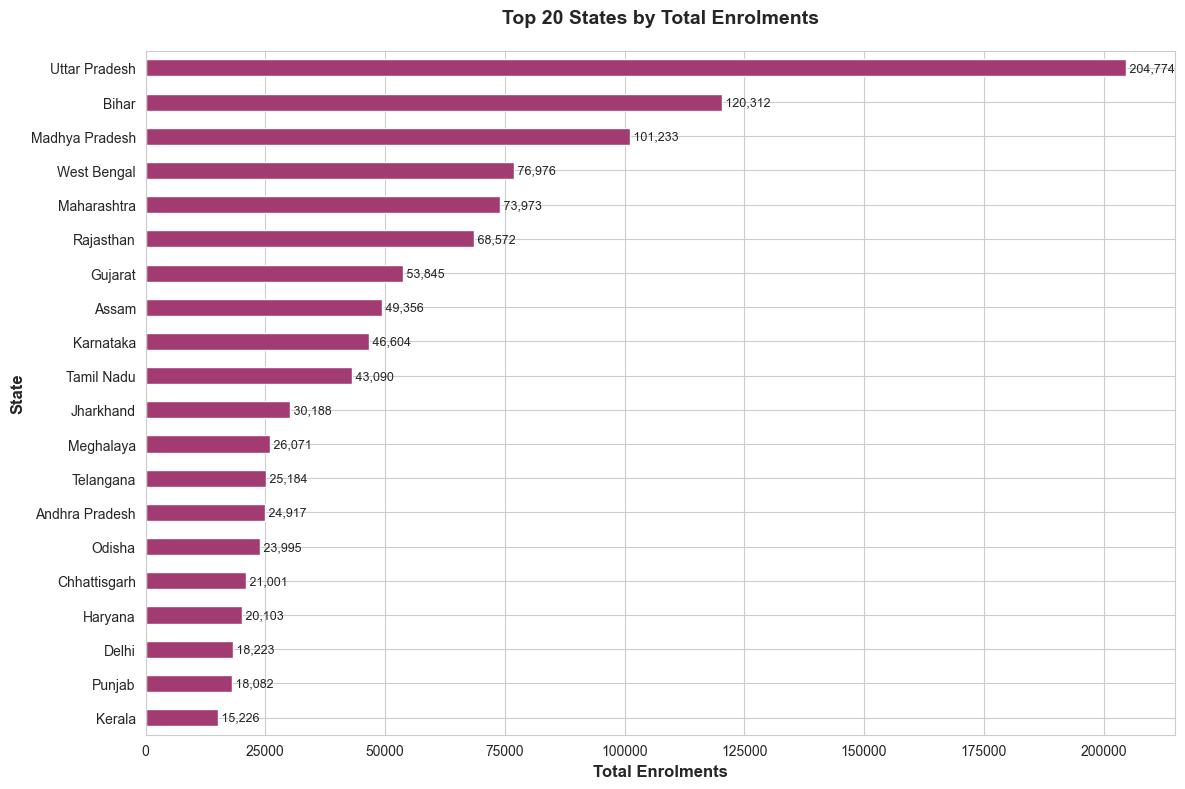


Top 10 States by Enrolments:
state
Uttar Pradesh     204774
Bihar             120312
Madhya Pradesh    101233
West Bengal        76976
Maharashtra        73973
Rajasthan          68572
Gujarat            53845
Assam              49356
Karnataka          46604
Tamil Nadu         43090
Name: total_enrolments, dtype: int64


In [5]:
# Top states by enrolments
state_enrolments = enrolment_df.groupby('state')['total_enrolments'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
state_enrolments.head(20).plot(kind='barh', ax=ax, color='#A23B72')
ax.set_xlabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_ylabel('State', fontweight='bold', fontsize=12)
ax.set_title('Top 20 States by Total Enrolments', fontweight='bold', fontsize=14, pad=20)
ax.invert_yaxis()

# Add value labels
for i, v in enumerate(state_enrolments.head(20).values):
    ax.text(v, i, f' {v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/figures/03_top_states_enrolments.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 States by Enrolments:")
print(state_enrolments.head(10))

Top 15 Districts by Enrolments:
state           district          
Maharashtra     Thane                 9141
Uttar Pradesh   Moradabad             8668
                Aligarh               7689
Karnataka       Bengaluru             7534
West Bengal     Murshidabad           7354
Uttar Pradesh   Lucknow               7325
                Agra                  7253
                Bahraich              7089
Bihar           Sitamarhi             6985
Meghalaya       East Khasi Hills      6868
Bihar           Pashchim Champaran    6857
Madhya Pradesh  Barwani               6776
Uttar Pradesh   Shahjahanpur          6685
Rajasthan       Alwar                 6654
                Jaipur                6444
Name: total_enrolments, dtype: int64


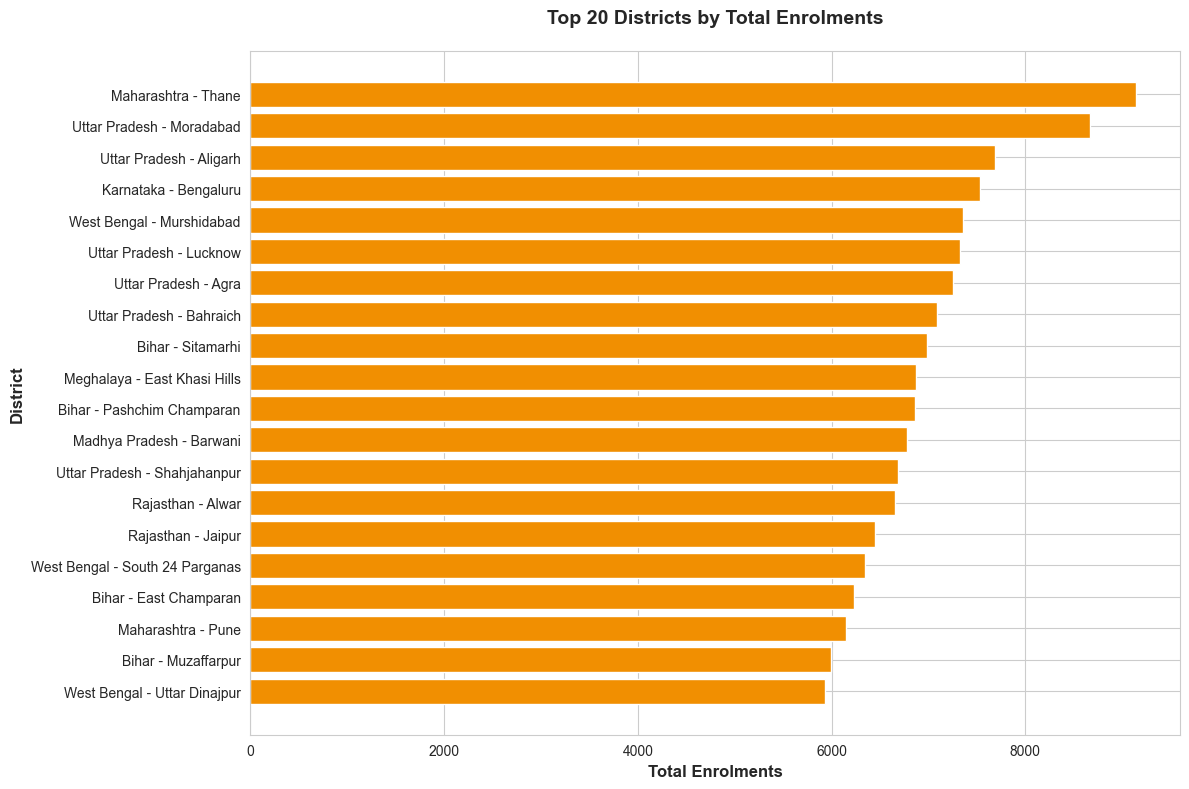

In [6]:
# District-level analysis
district_enrolments = enrolment_df.groupby(['state', 'district'])['total_enrolments'].sum().sort_values(ascending=False)

print("Top 15 Districts by Enrolments:")
print(district_enrolments.head(15))

fig, ax = plt.subplots(figsize=(12, 8))
top_districts = district_enrolments.head(20)
district_labels = [f"{state} - {dist}" for (state, dist) in top_districts.index]
ax.barh(district_labels, top_districts.values, color='#F18F01')
ax.set_xlabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_ylabel('District', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Districts by Total Enrolments', fontweight='bold', fontsize=14, pad=20)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/figures/04_top_districts_enrolments.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Update Activity Analysis

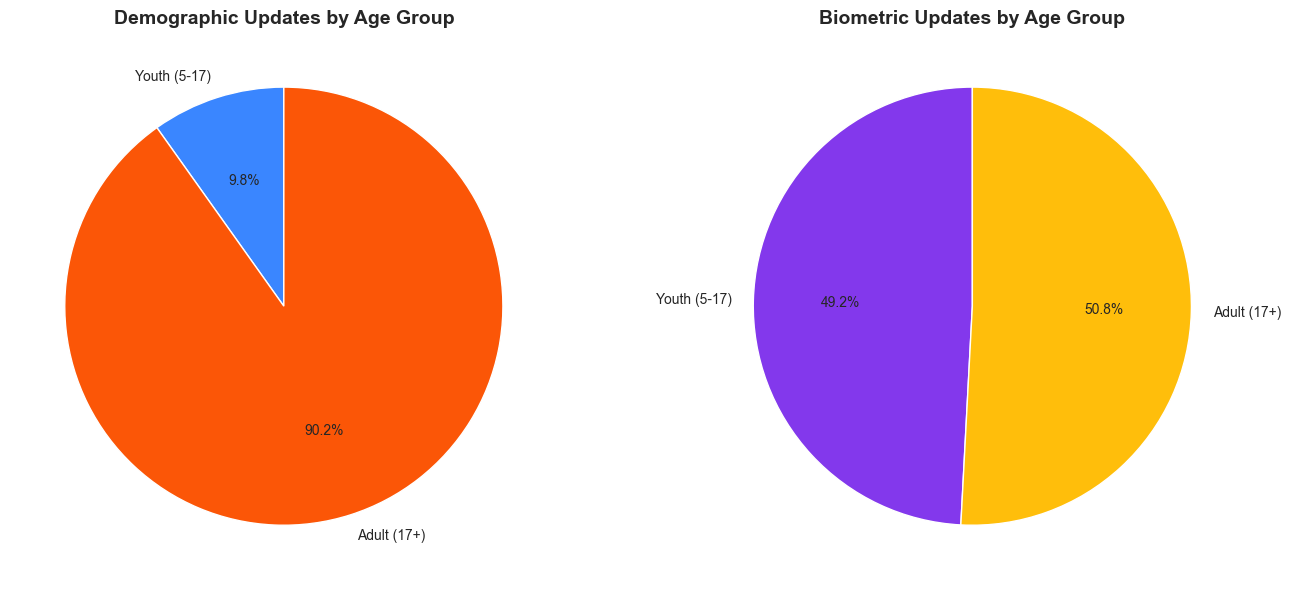


Update Activity Summary:
Total Demographic Updates: 9,407,318
Total Biometric Updates: 13,890,793


In [7]:
# Demographic update distribution
demo_totals = {
    'Youth (5-17)': demographic_df['demo_age_5_17'].sum(),
    'Adult (17+)': demographic_df['demo_age_17_'].sum()
}

bio_totals = {
    'Youth (5-17)': biometric_df['bio_age_5_17'].sum(),
    'Adult (17+)': biometric_df['bio_age_17_'].sum()
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Demographic updates
ax1.pie(demo_totals.values(), labels=demo_totals.keys(), autopct='%1.1f%%', 
        startangle=90, colors=['#3A86FF', '#FB5607'])
ax1.set_title('Demographic Updates by Age Group', fontweight='bold', fontsize=14)

# Biometric updates
ax2.pie(bio_totals.values(), labels=bio_totals.keys(), autopct='%1.1f%%', 
        startangle=90, colors=['#8338EC', '#FFBE0B'])
ax2.set_title('Biometric Updates by Age Group', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('../outputs/figures/05_update_distribution_by_age.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nUpdate Activity Summary:")
print(f"Total Demographic Updates: {sum(demo_totals.values()):,}")
print(f"Total Biometric Updates: {sum(bio_totals.values()):,}")

## 3. BIVARIATE ANALYSIS

### 3.1 Temporal vs. Volume Relationships

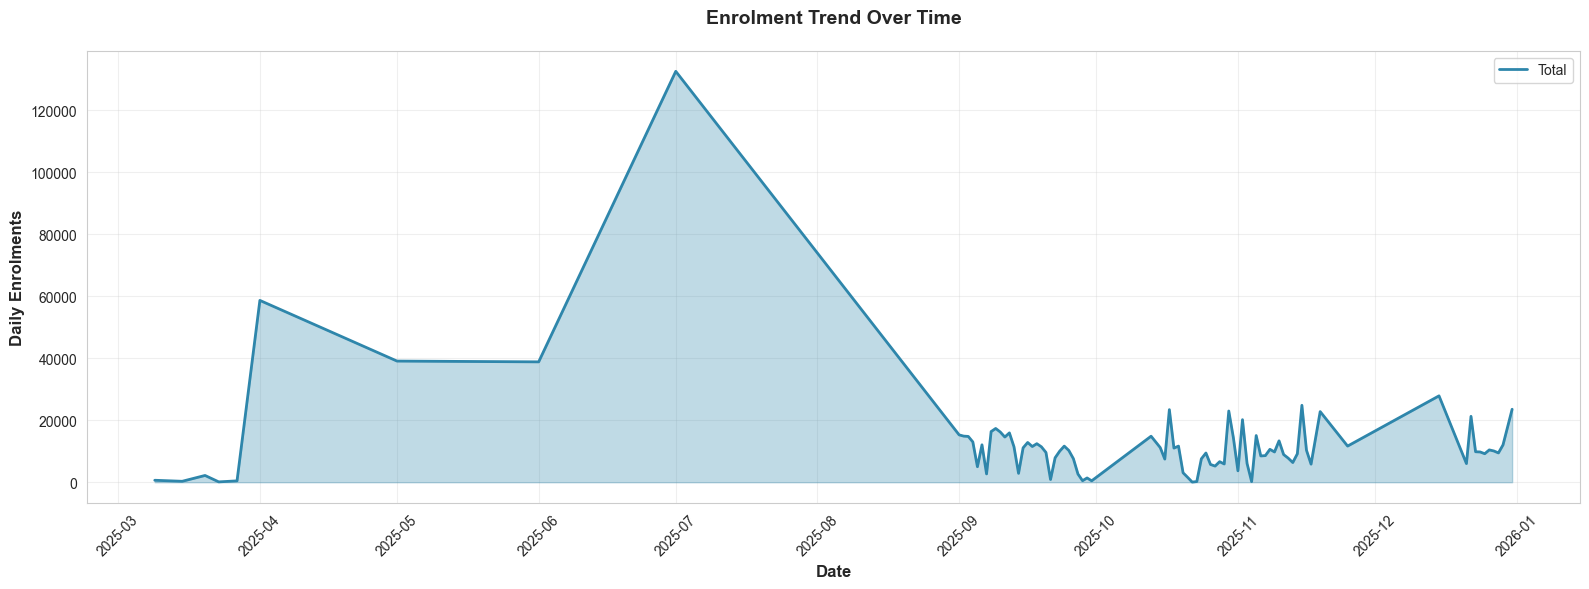

In [8]:
# Enrolments over time
daily_data = enrolment_df.groupby('date').agg({
    'total_enrolments': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum'
}).reset_index()

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(daily_data['date'], daily_data['total_enrolments'], linewidth=2, 
        color='#2E86AB', label='Total')
ax.fill_between(daily_data['date'], daily_data['total_enrolments'], 
                alpha=0.3, color='#2E86AB')

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Daily Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Enrolment Trend Over Time', fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/06_enrolment_trend_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

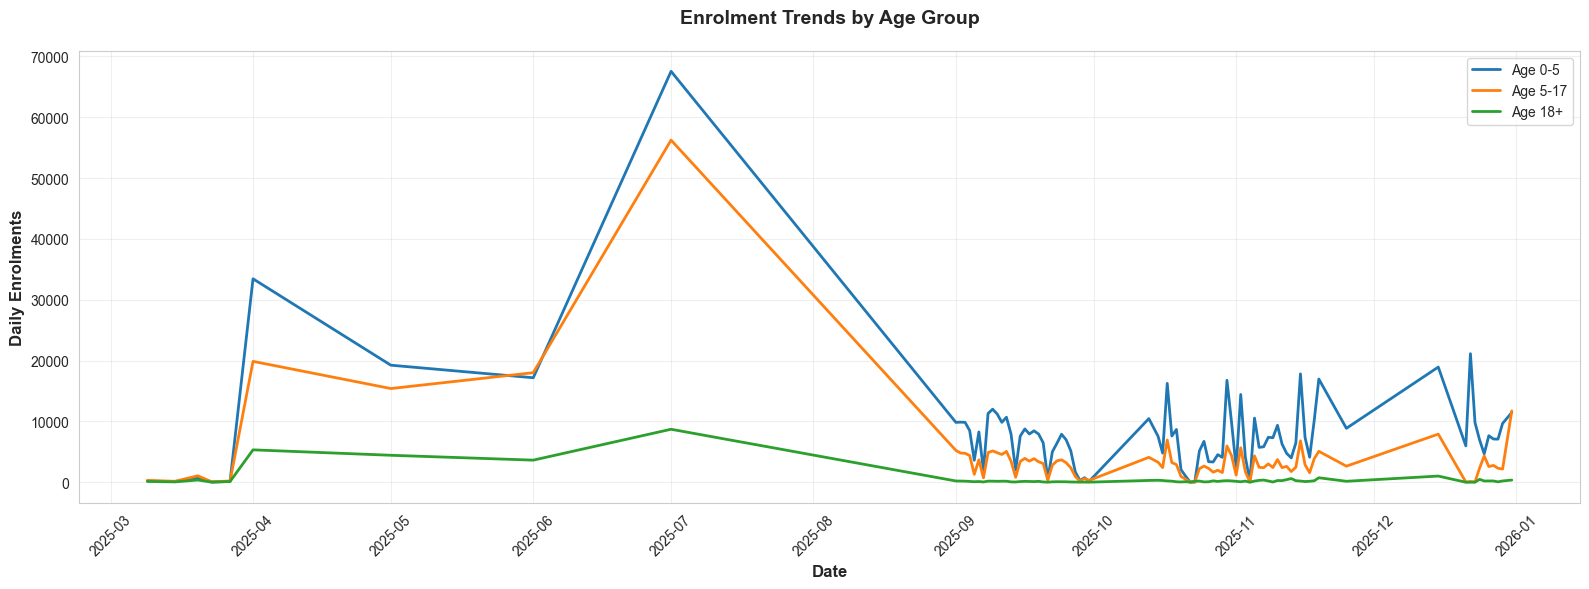

In [9]:
# Age group trends over time
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(daily_data['date'], daily_data['age_0_5'], label='Age 0-5', linewidth=2)
ax.plot(daily_data['date'], daily_data['age_5_17'], label='Age 5-17', linewidth=2)
ax.plot(daily_data['date'], daily_data['age_18_greater'], label='Age 18+', linewidth=2)

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Daily Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Enrolment Trends by Age Group', fontweight='bold', fontsize=14, pad=20)
ax.legend()
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/figures/07_age_group_trends.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2 Day of Week Analysis

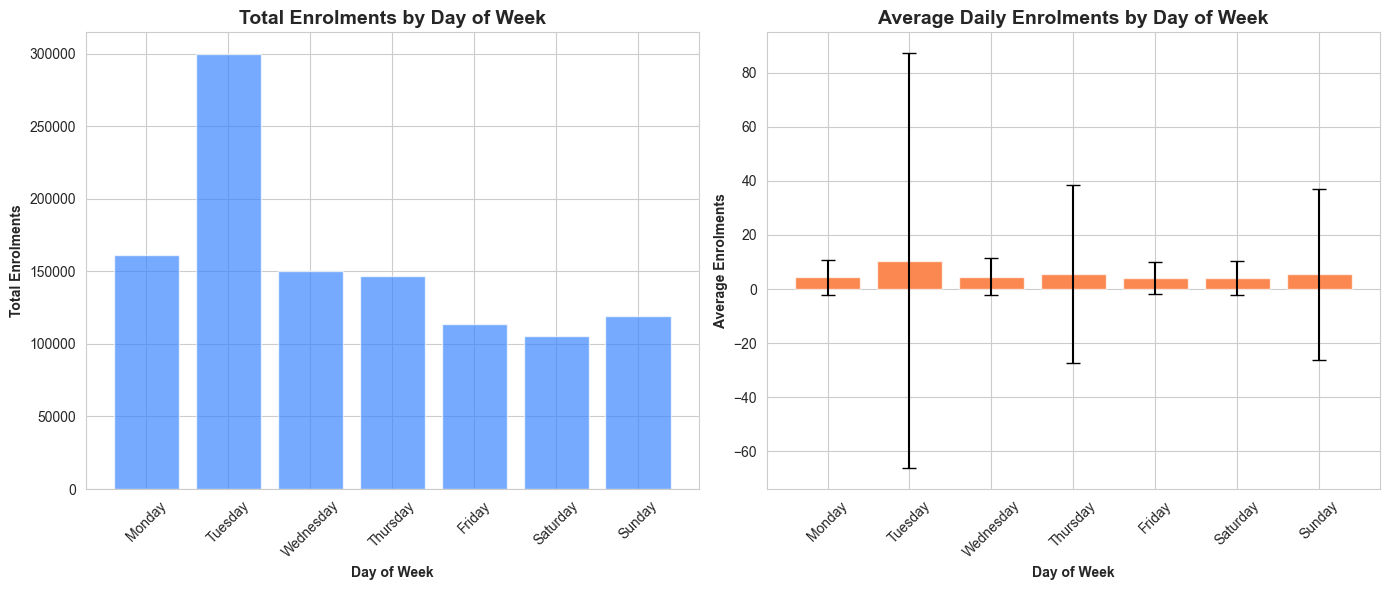


Day of Week Statistics:
 day_name    sum      mean
   Monday 161355  4.319618
  Tuesday 299615 10.493661
Wednesday 150089  4.570728
 Thursday 146531  5.690745
   Friday 113440  4.101081
 Saturday 105605  4.070341
   Sunday 119508  5.393690


In [10]:
# Day of week patterns
dow_data = enrolment_df.groupby('day_of_week')['total_enrolments'].agg(['sum', 'mean', 'std']).reset_index()
dow_data['day_name'] = dow_data['day_of_week'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Total by day of week
ax1.bar(dow_data['day_name'], dow_data['sum'], color='#3A86FF', alpha=0.7)
ax1.set_xlabel('Day of Week', fontweight='bold')
ax1.set_ylabel('Total Enrolments', fontweight='bold')
ax1.set_title('Total Enrolments by Day of Week', fontweight='bold', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Average by day of week with error bars
ax2.bar(dow_data['day_name'], dow_data['mean'], yerr=dow_data['std'], 
        color='#FB5607', alpha=0.7, capsize=5)
ax2.set_xlabel('Day of Week', fontweight='bold')
ax2.set_ylabel('Average Enrolments', fontweight='bold')
ax2.set_title('Average Daily Enrolments by Day of Week', fontweight='bold', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/08_day_of_week_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDay of Week Statistics:")
print(dow_data[['day_name', 'sum', 'mean']].to_string(index=False))

### 3.3 Month-wise Seasonality

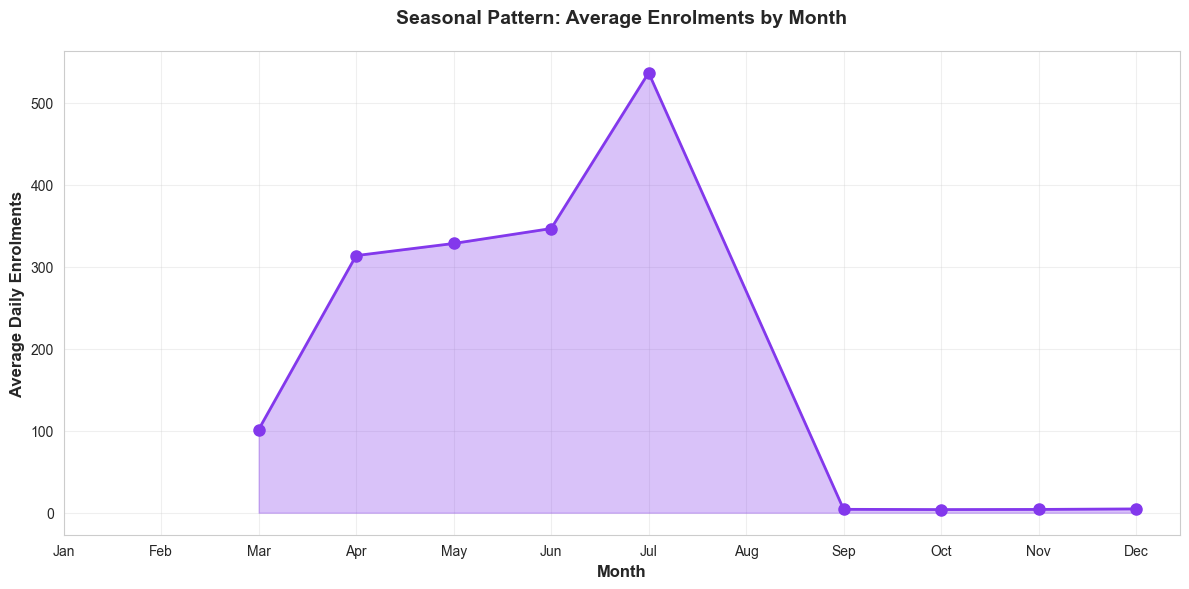


Monthly Average Enrolments:
  Mar: 101
  Apr: 313
  May: 328
  Jun: 346
  Jul: 536
  Sep: 4
  Oct: 4
  Nov: 4
  Dec: 5


In [11]:
# Monthly patterns
monthly_data = enrolment_df.groupby(['year', 'month'])['total_enrolments'].sum().reset_index()
monthly_data['year_month'] = monthly_data['year'].astype(str) + '-' + monthly_data['month'].astype(str).str.zfill(2)

# Average by month across years
month_avg = enrolment_df.groupby('month')['total_enrolments'].mean().reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(month_avg['month'], month_avg['total_enrolments'], marker='o', 
        linewidth=2, markersize=8, color='#8338EC')
ax.fill_between(month_avg['month'], month_avg['total_enrolments'], alpha=0.3, color='#8338EC')
ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Daily Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Seasonal Pattern: Average Enrolments by Month', fontweight='bold', fontsize=14, pad=20)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/09_monthly_seasonality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMonthly Average Enrolments:")
for idx, row in month_avg.iterrows():
    print(f"  {month_names[int(row['month'])-1]}: {row['total_enrolments']:,.0f}")

### 3.4 State vs. Age Group Analysis

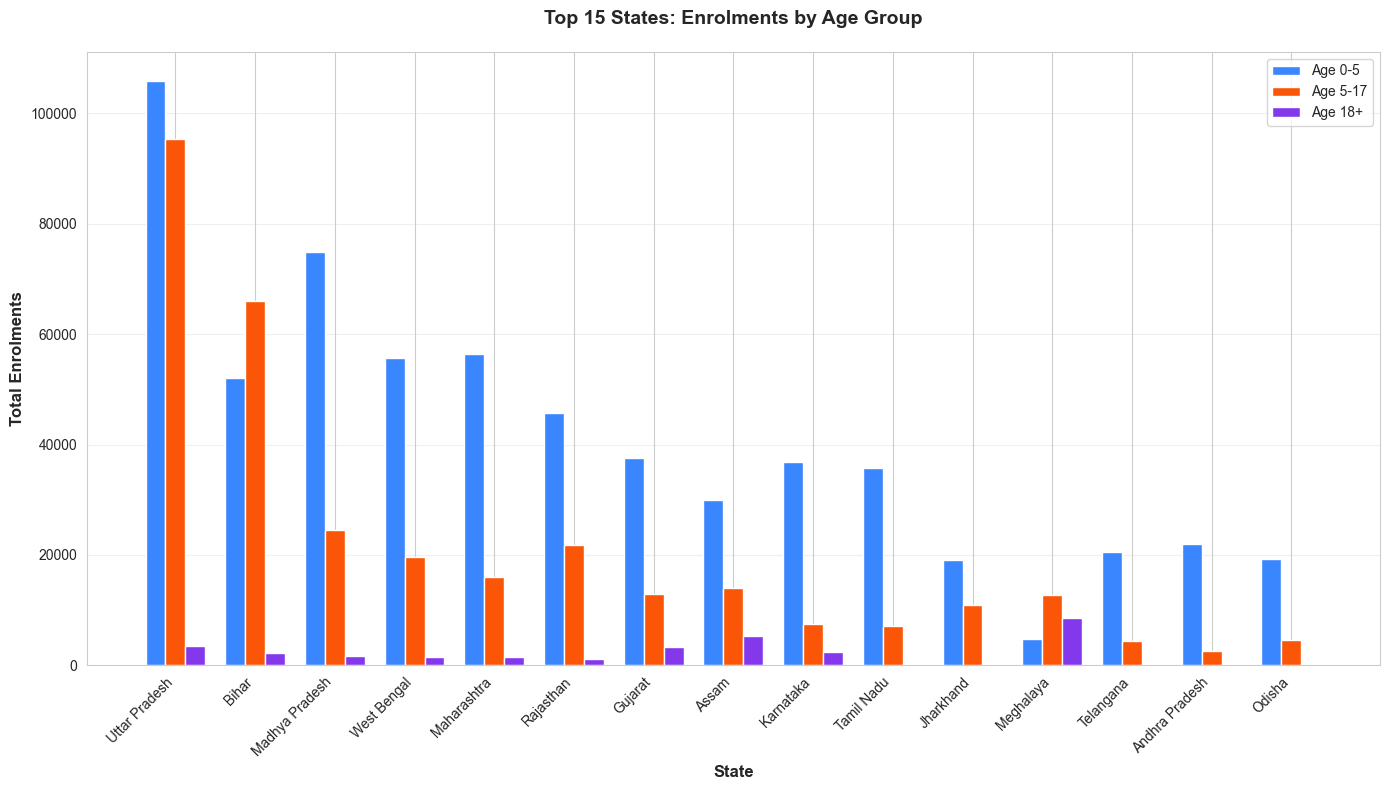

In [12]:
# Top states by age group
state_age_data = enrolment_df.groupby('state').agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrolments': 'sum'
}).sort_values('total_enrolments', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(state_age_data))
width = 0.25

ax.bar(x - width, state_age_data['age_0_5'], width, label='Age 0-5', color='#3A86FF')
ax.bar(x, state_age_data['age_5_17'], width, label='Age 5-17', color='#FB5607')
ax.bar(x + width, state_age_data['age_18_greater'], width, label='Age 18+', color='#8338EC')

ax.set_xlabel('State', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Enrolments', fontweight='bold', fontsize=12)
ax.set_title('Top 15 States: Enrolments by Age Group', fontweight='bold', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(state_age_data.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/10_state_age_group_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. TRIVARIATE ANALYSIS

### 4.1 State × Time × Age Group

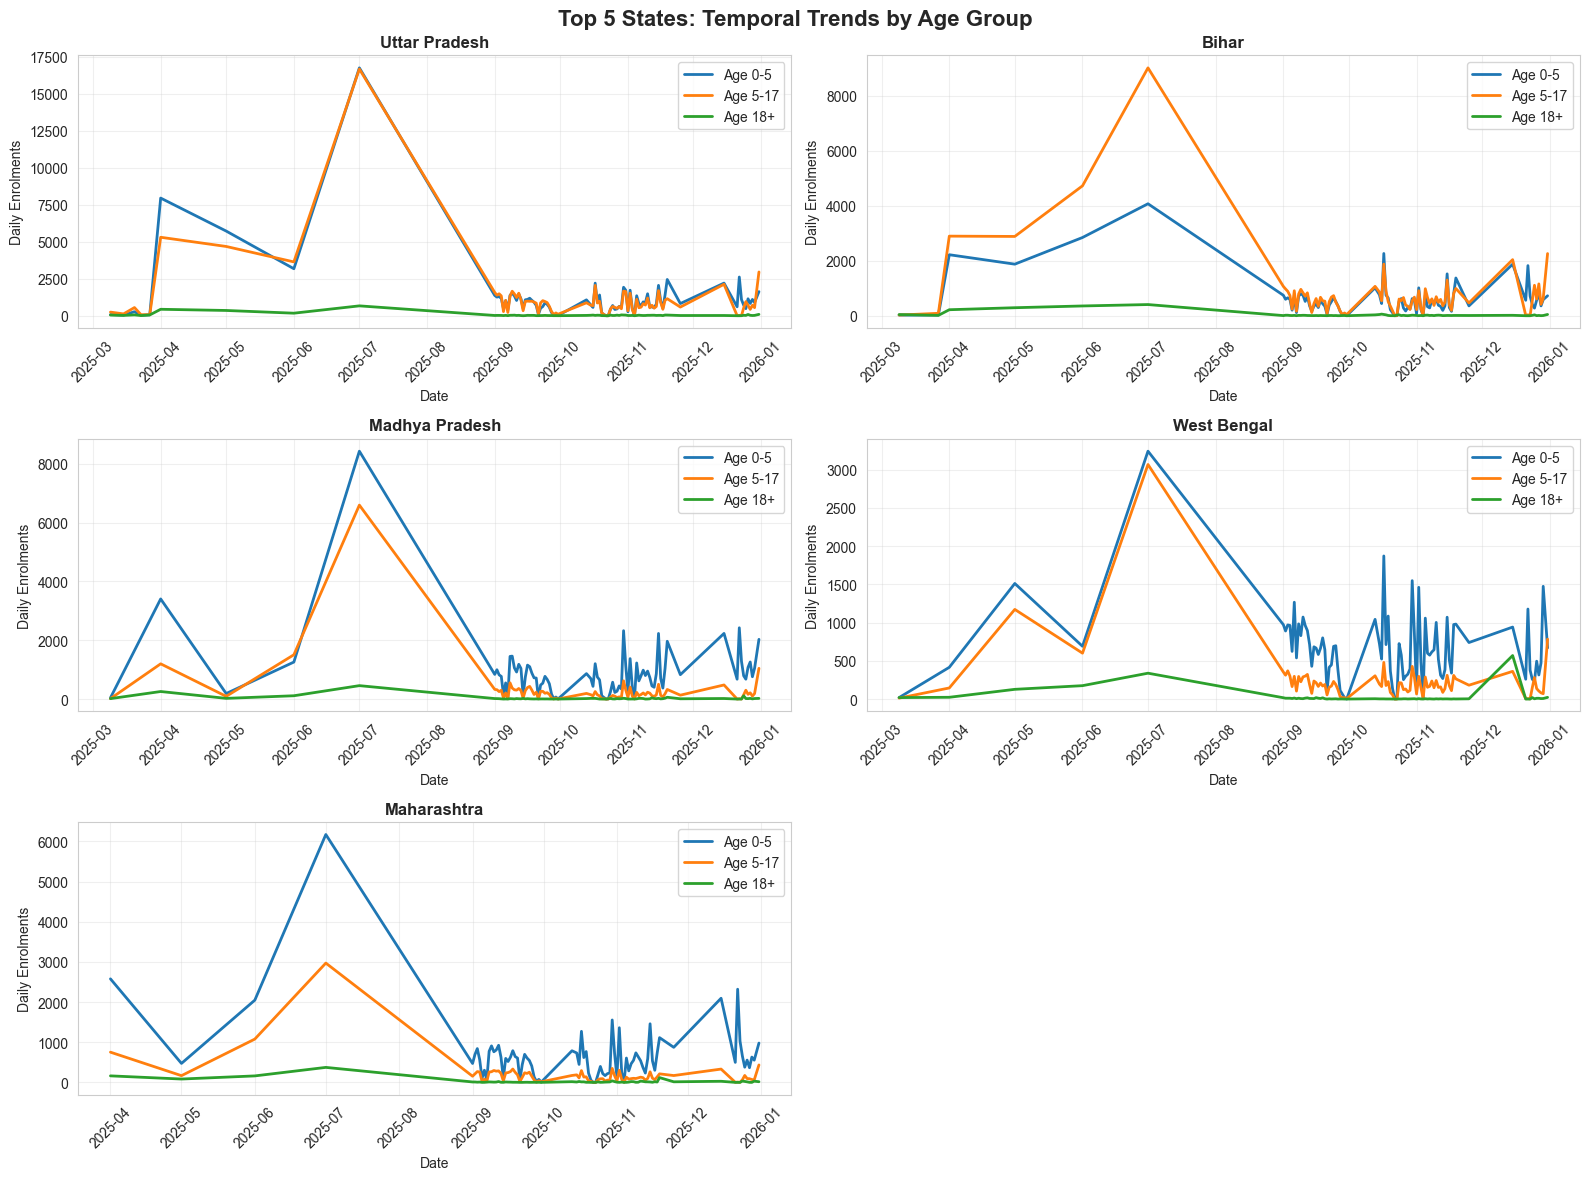

In [13]:
# Top 5 states over time by age group
top_states = enrolment_df.groupby('state')['total_enrolments'].sum().nlargest(5).index

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Top 5 States: Temporal Trends by Age Group', fontweight='bold', fontsize=16)

for idx, state in enumerate(top_states):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    state_data = enrolment_df[enrolment_df['state'] == state].groupby('date').agg({
        'age_0_5': 'sum',
        'age_5_17': 'sum',
        'age_18_greater': 'sum'
    })
    
    ax.plot(state_data.index, state_data['age_0_5'], label='Age 0-5', linewidth=2)
    ax.plot(state_data.index, state_data['age_5_17'], label='Age 5-17', linewidth=2)
    ax.plot(state_data.index, state_data['age_18_greater'], label='Age 18+', linewidth=2)
    
    ax.set_title(state, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Enrolments')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# Hide empty subplot
if len(top_states) < 6:
    axes[2, 1].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/11_trivariate_state_time_age.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Heatmap: Month × State × Enrolments

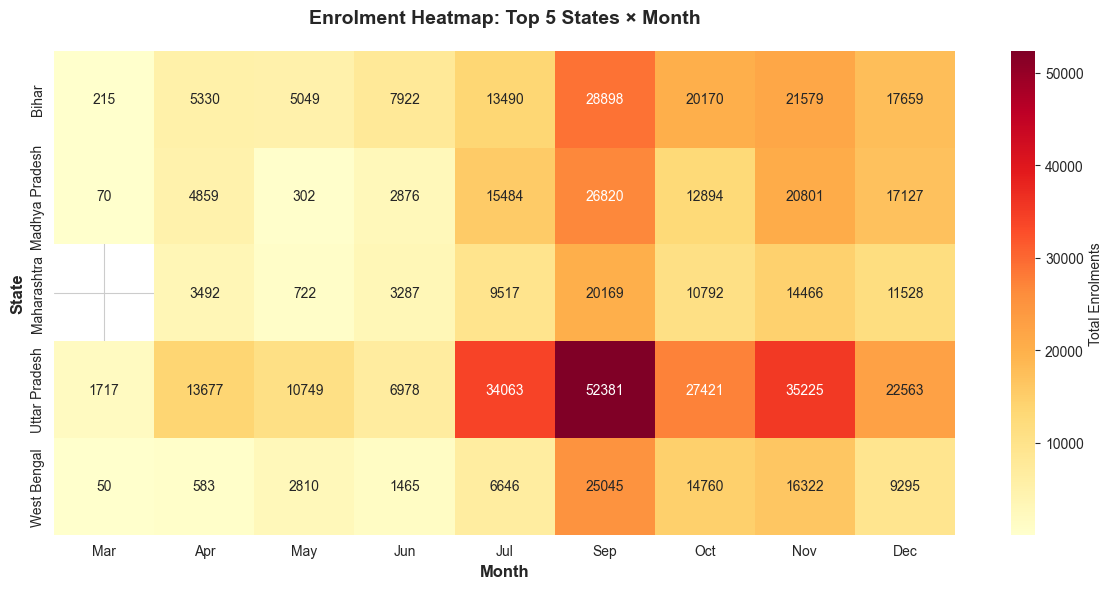

In [14]:
# Create pivot table for heatmap
heatmap_data = enrolment_df[enrolment_df['state'].isin(top_states)].pivot_table(
    index='state',
    columns='month',
    values='total_enrolments',
    aggfunc='sum'
)

fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', 
            cbar_kws={'label': 'Total Enrolments'}, ax=ax)

ax.set_title('Enrolment Heatmap: Top 5 States × Month', fontweight='bold', fontsize=14, pad=20)
ax.set_xlabel('Month', fontweight='bold', fontsize=12)
ax.set_ylabel('State', fontweight='bold', fontsize=12)

# Fix: Only set labels for months that exist in the data
month_labels = [month_names[int(m)-1] for m in heatmap_data.columns]
ax.set_xticklabels(month_labels, rotation=0)

plt.tight_layout()
plt.savefig('../outputs/figures/12_heatmap_state_month.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. CORRELATION ANALYSIS

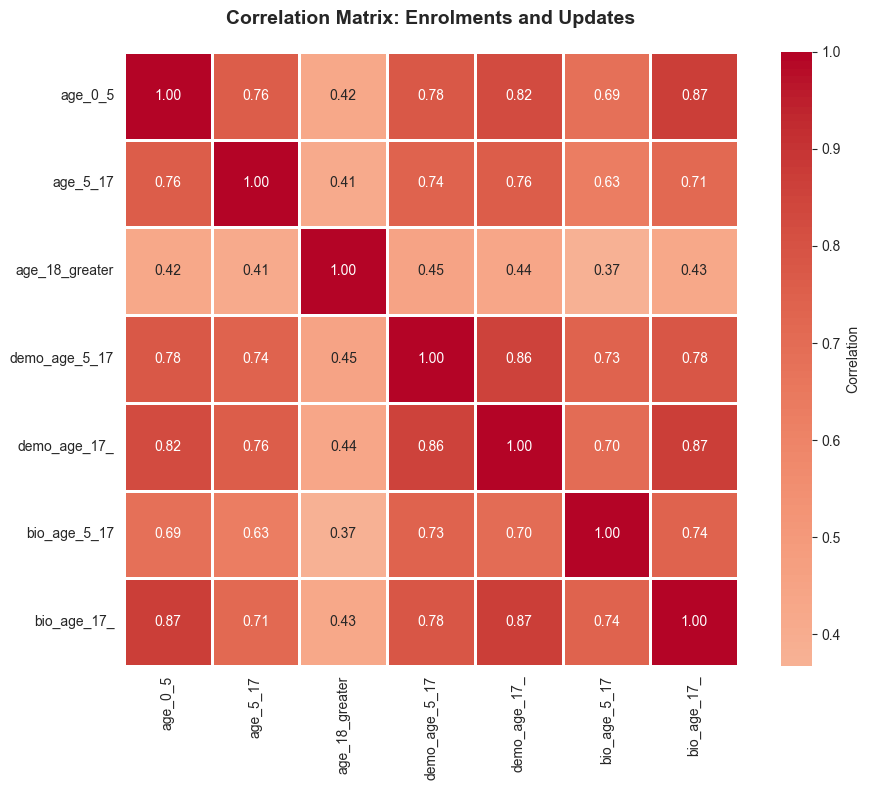


Key Correlations:
Strong positive correlations (>0.5):
  age_0_5 ↔ age_5_17: 0.763
  age_0_5 ↔ demo_age_5_17: 0.776
  age_0_5 ↔ demo_age_17_: 0.824
  age_0_5 ↔ bio_age_5_17: 0.687
  age_0_5 ↔ bio_age_17_: 0.869
  age_5_17 ↔ demo_age_5_17: 0.740
  age_5_17 ↔ demo_age_17_: 0.759
  age_5_17 ↔ bio_age_5_17: 0.625
  age_5_17 ↔ bio_age_17_: 0.712
  demo_age_5_17 ↔ demo_age_17_: 0.856
  demo_age_5_17 ↔ bio_age_5_17: 0.734
  demo_age_5_17 ↔ bio_age_17_: 0.784
  demo_age_17_ ↔ bio_age_5_17: 0.697
  demo_age_17_ ↔ bio_age_17_: 0.871
  bio_age_5_17 ↔ bio_age_17_: 0.736


In [15]:
# Correlation between age groups and updates
# Merge datasets for correlation analysis
merged_data = enrolment_df.merge(
    demographic_df[['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']],
    on=['date', 'state', 'district', 'pincode'],
    how='inner'
)

merged_data = merged_data.merge(
    biometric_df[['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']],
    on=['date', 'state', 'district', 'pincode'],
    how='inner'
)

# Select numeric columns for correlation
corr_cols = ['age_0_5', 'age_5_17', 'age_18_greater', 
             'demo_age_5_17', 'demo_age_17_', 'bio_age_5_17', 'bio_age_17_']
corr_matrix = merged_data[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=ax)

ax.set_title('Correlation Matrix: Enrolments and Updates', fontweight='bold', fontsize=14, pad=20)

plt.tight_layout()
plt.savefig('../outputs/figures/13_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Correlations:")
print("Strong positive correlations (>0.5):")
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if corr_matrix.iloc[i, j] > 0.5:
            print(f"  {corr_matrix.index[i]} ↔ {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

## 6. KEY INSIGHTS FROM EDA

### Summary of Findings

In [16]:
# Generate comprehensive summary
summary = f"""
{'='*80}
EXPLORATORY DATA ANALYSIS - KEY INSIGHTS
{'='*80}

1. AGE GROUP DISTRIBUTION:
   - Adults (18+): {age_totals['Age 18+']:,} ({age_totals['Age 18+']/total*100:.1f}%)
   - Youth (5-17): {age_totals['Age 5-17']:,} ({age_totals['Age 5-17']/total*100:.1f}%)
   - Children (0-5): {age_totals['Age 0-5']:,} ({age_totals['Age 0-5']/total*100:.1f}%)

2. GEOGRAPHIC CONCENTRATION:
   - Total states covered: {enrolment_df['state'].nunique()}
   - Total districts covered: {enrolment_df['district'].nunique()}
   - Top state: {state_enrolments.index[0]} ({state_enrolments.iloc[0]:,} enrolments)

3. TEMPORAL PATTERNS:
   - Date range: {enrolment_df['date'].min()} to {enrolment_df['date'].max()}
   - Average daily enrolments: {daily_enrolments.mean():,.0f}
   - Peak day: {daily_enrolments.idxmax()} ({daily_enrolments.max():,.0f} enrolments)
   
4. UPDATE ACTIVITY:
   - Total demographic updates: {sum(demo_totals.values()):,}
   - Total biometric updates: {sum(bio_totals.values()):,}
   - Demo/Bio ratio: {sum(demo_totals.values())/sum(bio_totals.values()):.2f}

5. SEASONALITY:
   - Highest month: {month_names[month_avg.loc[month_avg['total_enrolments'].idxmax(), 'month'].astype(int)-1]}
   - Lowest month: {month_names[month_avg.loc[month_avg['total_enrolments'].idxmin(), 'month'].astype(int)-1]}

{'='*80}
"""

print(summary)

# Save summary
with open('../outputs/insights/eda_summary.txt', 'w') as f:
    f.write(summary)

print("✓ Summary saved to outputs/insights/eda_summary.txt")


EXPLORATORY DATA ANALYSIS - KEY INSIGHTS

1. AGE GROUP DISTRIBUTION:
   - Adults (18+): 36,284 (3.3%)
   - Youth (5-17): 346,153 (31.6%)
   - Children (0-5): 713,706 (65.1%)

2. GEOGRAPHIC CONCENTRATION:
   - Total states covered: 48
   - Total districts covered: 922
   - Top state: Uttar Pradesh (204,774 enrolments)

3. TEMPORAL PATTERNS:
   - Date range: 2025-03-09 00:00:00 to 2025-12-31 00:00:00
   - Average daily enrolments: 12,456
   - Peak day: 2025-07-01 00:00:00 (132,479 enrolments)
   
4. UPDATE ACTIVITY:
   - Total demographic updates: 9,407,318
   - Total biometric updates: 13,890,793
   - Demo/Bio ratio: 0.68

5. SEASONALITY:
   - Highest month: Jul
   - Lowest month: Oct


✓ Summary saved to outputs/insights/eda_summary.txt


## Next Steps

1. **Temporal & Spatial Analysis**: Deep dive into time series patterns and geographic trends
2. **Anomaly Detection**: Identify unusual patterns and outliers
3. **Predictive Modeling**: Forecast future enrolment and update demand
4. **Insights Compilation**: Translate findings into actionable recommendations